<a href="https://colab.research.google.com/github/bernarducs/caged_time_series/blob/master/Estudo_estoques_formais_PERNAMBUCO_SARIMAX_com_grid_search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Objetivo
### Abaixo, utilizaremos funções que buscarão os melhores parâmetros para modelagem do método ARIMAX com fator sazonal, usando como variável exógena o Ibc.

Based on article: https://machinelearningmastery.com/how-to-grid-search-sarima-model-hyperparameters-for-time-series-forecasting-in-python/

## Pacotes

In [1]:
from math import sqrt
from itertools import product
import pandas as pd

In [2]:
# viz
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("talk")

In [3]:
# multiprocessing
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings

In [4]:
# stats
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Datasets

#### Estoques

In [5]:
file_path = "/content/drive/My Drive/Colab Notebooks/emprego/bases/estoques/estoque_pe.csv"
df = pd.read_csv(file_path, index_col='ano_mes', sep=';')
df.index = pd.to_datetime(df.index, format="%Y%m")
df.tail()

,estoques
ano_mes,
2020-05-01,1167301
2020-06-01,1163587
2020-07-01,1169034
2020-08-01,1181355
2020-09-01,1203156


#### Ibc

In [6]:
file_ibcpe = '/content/drive/My Drive/Colab Notebooks/emprego/bases/IBCR-PE.csv'
df_ibc = pd.read_csv(file_ibcpe, sep=';', dtype={'data': 'str', 'indice':'float', 'indice_ajus':'float'})
df_ibc['data'] = pd.to_datetime(df_ibc.data, format="%Y-%m-%d")
df_ibc.set_index('data', inplace=True)
exog = pd.concat(
    [df_ibc.indice_ajus.loc['2010-12-01':],
    df_ibc.indice_ajus.shift(periods=1, freq="infer").tail(1)])
exog.tail()

data
2020-05-01    134.86
2020-06-01    139.25
2020-07-01    145.77
2020-08-01    146.05
2020-09-01    146.05
Name: indice_ajus, dtype: float64

#### Saldo

In [7]:
file_path2 = "/content/drive/My Drive/Colab Notebooks/emprego/bases/saldos/saldo_pe.csv"
df_saldo = pd.read_csv(file_path2, sep=';')
df_saldo.set_index('ano', inplace=True)
df_saldo.index = pd.to_datetime(df_saldo.index, format="%Y")
df_saldo.tail()

,saldo
ano,
2016-01-01,-47617
2017-01-01,-6498
2018-01-01,4091
2019-01-01,9696
2020-01-01,-28963


## Rotinas

Aqui temos funções para o sarima em 1 passo (faz a predição para t+1). A próxima função é raiz quadrada dos erros médios e por fim a função responsável por separação do dataset entre teste e treino.

In [8]:
# one-step sarima forecast
def sarimax_forecast(history, config, exog=None):
	order, sorder, trend = config
	# define model
	model = SARIMAX(history, exog=exog, order=order, seasonal_order=sorder, trend=trend, 
                 enforce_stationarity=False, enforce_invertibility=False)
	# fit model
	model_fit = model.fit(disp=False)
	# make one step forecast
	yhat = model_fit.predict()
	return yhat
 
# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))
 
# split a univariate dataset into train/test sets
def train_test_split(data, percent_test=0.25):
  n_test = int(len(data) * percent_test)
  return data[:-n_test], data[-n_test:]

Aqui usamos a funções acima retornando o quadrado dos desvios.

In [9]:
# walk-forward validation for univariate data
def walk_forward_validation(data, percent_test, cfg, exog=None):
  # split dataset
  train, _ = train_test_split(data, percent_test)

  if exog is not None:
    exog, _ = train_test_split(exog, percent_test)

  # fit model and make forecast for history
  yhat = sarimax_forecast(train, cfg, exog)

  # estimate prediction error
  error = measure_rmse(train, yhat)
  return error  

Avalia qual a melhor configuração de parâmetros `cfg` tem a melhor avaliação, ou seja, o menor erro.

In [10]:
def score_model(data, n_test, cfg, exog=None, debug=False):
  result = None
  # convert config to a key
  key = str(cfg)
  # show all warnings and fail on exception if debugging
  if debug:
    result = walk_forward_validation(data, n_test, cfg, exog)
  else:
    # one failure during model validation suggests an unstable config
    try:
      # never show warnings when grid searching, too noisy
      with catch_warnings():
        filterwarnings("ignore")
        result = walk_forward_validation(data, n_test, cfg, exog)
    except:
      error = None
      print("Exception")
  # check for an interesting result
  if result is not None:
    print(' > Model{}: {:.2f}'.format(key, result))
  return (key, result)

In [11]:
# grid search configs
def grid_search(data, n_test, cfg_list, exog=None, parallel=True):
  scores = None
  if parallel:
    # execute configs in parallel
    executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
    tasks = (delayed(score_model)(data, n_test, cfg, exog) for cfg in cfg_list)
    scores = executor(tasks)
  else:
    scores = [score_model(data, n_test, cfg, exog) for cfg in cfg_list]
  # remove empty results
  scores = [r for r in scores if r[1] != None]
  # sort configs by error, asc
  scores.sort(key=lambda tup: tup[1])
  return scores

In [39]:
# evaluating grid search results for test data
def grid_search_test_results(data, scores, exog=None, ntop_scores=5):

  if ntop_scores > len(scores):
    ntop_scores = 5

  scores_test = list()
  _, test = train_test_split(data, percent_test=0.45)
  
  if exog is None:
    ex_test = None
  else:
    _, ex_test = train_test_split(exog, percent_test=0.45)  

  for cfg_str, _ in scores[:ntop_scores]:
    cfg = eval(cfg_str)
    with catch_warnings():
      filterwarnings("ignore")
      yhat = sarimax_forecast(test, cfg, ex_test)
    error = measure_rmse(test, yhat)
    result = (cfg_str, error)
    print(result)
    scores_test.append(result)
  
  scores_test.sort(key=lambda tup: tup[1])
  return scores_test

In [13]:
def plot_model(data, cfg, exog=None):
  order = cfg[0]
  s_order = cfg[1]
  trend = cfg[2]
  sarimax_pred = SARIMAX(
      endog=df, exog=exog, order=order, seasonal_order=s_order, trend=trend,
      enforce_stationarity=False, enforce_invertibility=False)

  model_sarimax_pred = sarimax_pred.fit(disp=False)

  previsao_sarimax = model_sarimax_pred.predict()

  error = measure_rmse(df, previsao_sarimax)
  print('Error:', error)

  plt.figure(figsize=(22, 10))
  plt.plot(previsao_sarimax[10:], label = 'forecast')
  plt.plot(df[10:], label = 'target')
  plt.title('Target x Forecast')
  plt.legend()
  plt.show()

In [14]:
def sarima_configs(seasonal=[12]):
  models = list()
  # define config lists
  p_params = [0, 1, 2]
  d_params = [0, 1]
  q_params = [0, 1, 2]
  t_params = ['n','c','t','ct']
  P_params = [0, 1, 2]
  D_params = [0, 1]
  Q_params = [0, 1]
  m_params = seasonal
  # create config instances
  for p, d, q, t, P, D, Q, m in product(p_params, d_params, q_params, t_params, P_params, D_params, Q_params, m_params):
    cfg = [(p,d,q), (P,D,Q,m), t]
    models.append(cfg)
  return models

## Gerando modelo

In [33]:
cfg_list = sarima_configs(seasonal=[12])
scores = grid_search(df, 0.25, cfg_list)

 > Model[(0, 0, 0), (0, 0, 0, 12), 'n']: 1273182.59
 > Model[(0, 0, 0), (0, 1, 0, 12), 'n']: 439778.47
 > Model[(0, 0, 0), (0, 0, 1, 12), 'n']: 811292.13
 > Model[(0, 0, 0), (1, 0, 0, 12), 'n']: 439773.83
 > Model[(0, 0, 0), (0, 1, 1, 12), 'n']: 438749.40
 > Model[(0, 0, 0), (1, 1, 0, 12), 'n']: 470891.93
 > Model[(0, 0, 0), (1, 0, 1, 12), 'n']: 438527.61
 > Model[(0, 0, 0), (2, 0, 0, 12), 'n']: 477855.13
 > Model[(0, 0, 0), (1, 1, 1, 12), 'n']: 478114.48
 > Model[(0, 0, 0), (2, 1, 0, 12), 'n']: 548243.19
 > Model[(0, 0, 0), (2, 0, 1, 12), 'n']: 442219.15
 > Model[(0, 0, 0), (0, 0, 0, 12), 'c']: 137505.57
 > Model[(0, 0, 0), (0, 0, 1, 12), 'c']: 134061.10
 > Model[(0, 0, 0), (0, 1, 0, 12), 'c']: 438538.01
 > Model[(0, 0, 0), (0, 1, 1, 12), 'c']: 437717.38
 > Model[(0, 0, 0), (1, 0, 0, 12), 'c']: 136867.90
 > Model[(0, 0, 0), (1, 0, 1, 12), 'c']: 133463.85
 > Model[(0, 0, 0), (2, 1, 1, 12), 'n']: 646357.79
 > Model[(0, 0, 0), (1, 1, 0, 12), 'c']: 469059.74
 > Model[(0, 0, 0), (2, 0, 0, 

In [109]:
scores[:5]

[("[(0, 1, 2), (0, 0, 1, 12), 'ct']", 124074.87851565355),
 ("[(0, 1, 2), (0, 0, 1, 12), 't']", 124082.24544102851),
 ("[(0, 1, 2), (0, 0, 1, 12), 'c']", 124082.60467521336),
 ("[(0, 1, 2), (0, 0, 1, 12), 'n']", 124082.83097067631),
 ("[(0, 1, 1), (0, 0, 1, 12), 'ct']", 124085.31624625249)]

In [110]:
test_scores = grid_search_test_results(df, scores, exog, ntop_scores=3)

("[(0, 1, 2), (0, 0, 1, 12), 'ct']", 133996.68568967967)
("[(0, 1, 2), (0, 0, 1, 12), 't']", 133997.76486645255)
("[(0, 1, 2), (0, 0, 1, 12), 'c']", 133997.39382966617)


In [111]:
test_scores

[("[(0, 1, 2), (0, 0, 1, 12), 'ct']", 133996.68568967967),
 ("[(0, 1, 2), (0, 0, 1, 12), 'c']", 133997.39382966617),
 ("[(0, 1, 2), (0, 0, 1, 12), 't']", 133997.76486645255)]

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Error: 107861.09526471571


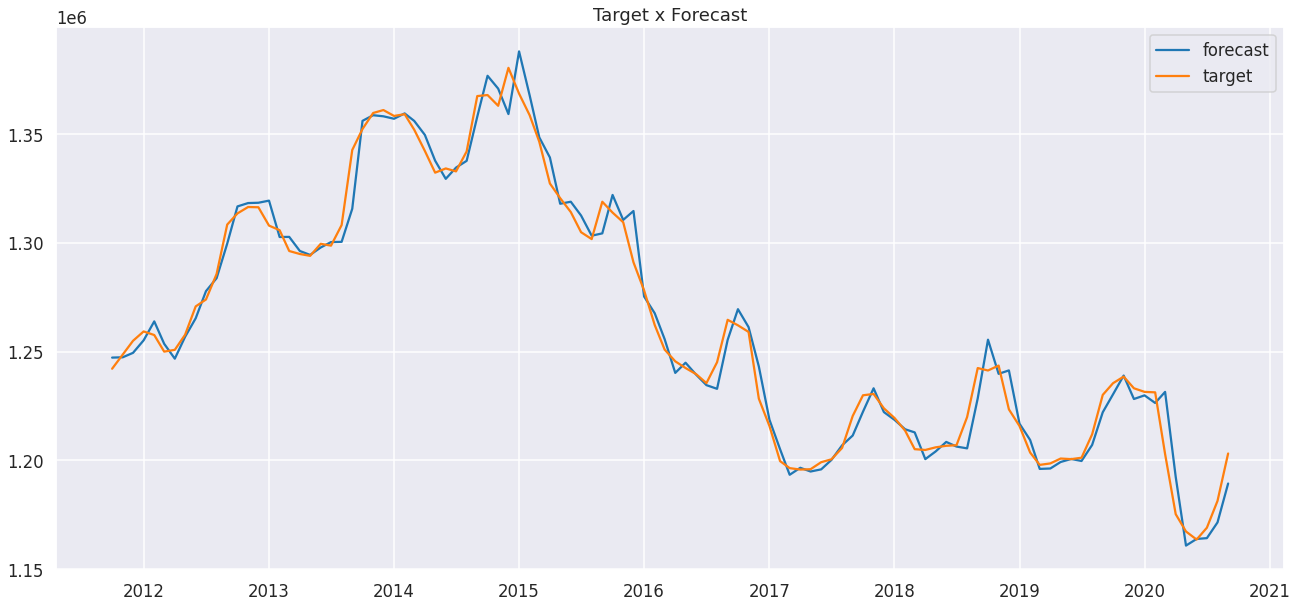

In [112]:
plot_model(df, eval(test_scores[0][0]))

___

## Previsão

In [126]:
cfg = eval(test_scores[0][0])
# cfg = [(0, 1, 2), (0, 0, 1, 12), 'n']
order = cfg[0]
s_order = cfg[1]
trend = cfg[2]
sarimax_pred = SARIMAX(
    endog=df, exog=exog, order=order, seasonal_order=s_order, trend=trend,
    enforce_stationarity=False, enforce_invertibility=False)

model_sarimax_pred = sarimax_pred.fit(disp=False)

fcast_sarimax = model_sarimax_pred.get_forecast(3, exog=df_ibc.indice_ajus[-3:].values.reshape(-1, 1))


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [127]:
df_fcast = pd.concat([model_sarimax_pred.predict(), fcast_sarimax.predicted_mean], axis=0)

In [128]:
df_fcast.name = 'fcast'
df_fcast = pd.concat([df_fcast, fcast_sarimax.conf_int()], axis=1)
df_fcast.tail()

,fcast,lower estoques,upper estoques
2020-08-01,1.167464e+06,NaN,NaN
2020-09-01,1.187472e+06,NaN,NaN
2020-10-01,1.199228e+06,1.179737e+06,1.218719e+06
2020-11-01,1.212548e+06,1.180924e+06,1.244171e+06
2020-12-01,1.213461e+06,1.170686e+06,1.256236e+06


In [129]:
previsoes_sarimax = pd.concat(
    [df['estoques'], df_fcast],
    axis=1)

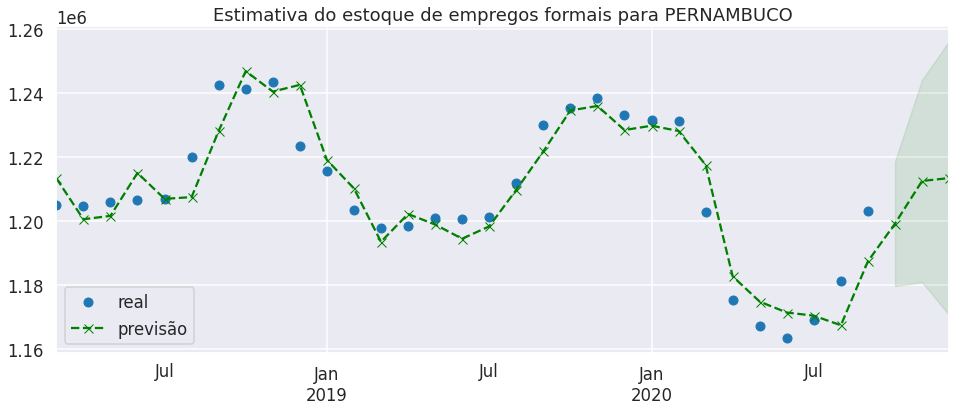

In [130]:
fig, ax = plt.subplots(figsize=(16, 6))
previsoes_sarimax.estoques.loc['2018-03-01':].plot(ax=ax, style='o', label='real')

previsoes_sarimax.fcast.loc['2018-03-01':].plot(ax=ax, style='g--x', label='previsão')

ax.fill_between(
    previsoes_sarimax.index, 
    previsoes_sarimax.iloc[:,2], 
    previsoes_sarimax.iloc[:,3], color='g', alpha=0.1)

plt.title('Estimativa do estoque de empregos formais para PERNAMBUCO')
legend = ax.legend(loc='lower left')

Até o fim do ano o saldo será:

In [131]:
fcast_sarimax.predicted_mean[-1] - df.estoques[-1]

10304.932933238335

In [132]:
pred2020df = pd.DataFrame(df_saldo.saldo[-1] + fcast_sarimax.predicted_mean[-1] - df.estoques[-1], 
                          index=["2020"], columns=['saldo'])
pred2020df.index.name = "Ano"
pred2020df.index = pd.to_datetime(pred2020df.index, format="%Y")

In [133]:
df_saldo_pred = pd.concat([df_saldo[1:][:-1], pred2020df], axis=0)
df_saldo_pred['saldo'] = df_saldo_pred.saldo.astype('int')
df_saldo_pred.index.name = 'data'

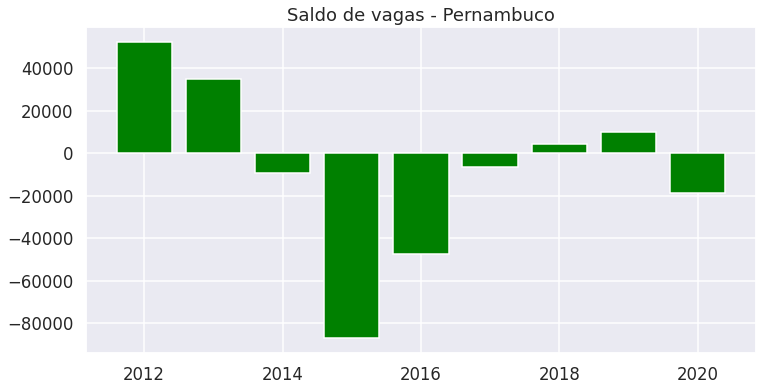

In [134]:
plt.figure(figsize=(12, 6))
plt.bar(df_saldo_pred.index.year, df_saldo_pred.saldo, color='g')
plt.title('Saldo de vagas - Pernambuco')
plt.show();

In [139]:
df_saldo_pred.to_csv("/content/drive/My Drive/Colab Notebooks/emprego/bases/saldo_pe_pred.csv")

In [136]:
df_saldo_pred.groupby(df_saldo_pred.index.year).sum()

,saldo
data,
2012,52256
2013,35068
2014,-9566
2015,-87207
2016,-47617
2017,-6498
2018,4091
2019,9696
2020,-18658


### Otimista

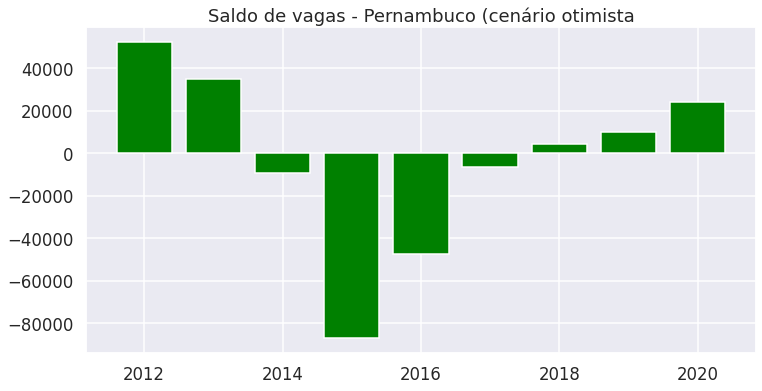

In [137]:
pred2020df_otimista = pd.DataFrame(df_saldo.saldo[-1] + df_fcast.iloc[-1:, 2][0] - df.estoques[-1], 
                          index=["2020"], columns=['saldo'])
pred2020df_otimista.index.name = "Ano"
pred2020df_otimista.index = pd.to_datetime(pred2020df_otimista.index, format="%Y")

df_saldo_pred_otimista = pd.concat([df_saldo[1:][:-1], pred2020df_otimista], axis=0)
df_saldo_pred_otimista['saldo'] = df_saldo_pred_otimista.saldo.astype('int')
df_saldo_pred_otimista.index.name = 'data'

plt.figure(figsize=(12, 6))
plt.bar(df_saldo_pred_otimista.index.year, df_saldo_pred_otimista.saldo, color='g')
plt.title('Saldo de vagas - Pernambuco (cenário otimista')
plt.show();

### Pessimista

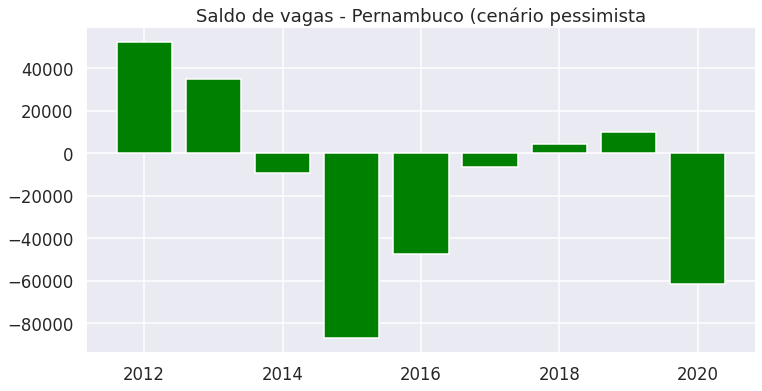

In [138]:
pred2020df_pess = pd.DataFrame(df_saldo.saldo[-1] + df_fcast.iloc[-1:, 1][0] - df.estoques[-1], 
                          index=["2020"], columns=['saldo'])
pred2020df_pess.index.name = "Ano"
pred2020df_pess.index = pd.to_datetime(pred2020df_pess.index, format="%Y")

df_saldo_pred_pess = pd.concat([df_saldo[1:][:-1], pred2020df_pess], axis=0)
df_saldo_pred_pess['saldo'] = df_saldo_pred_pess.saldo.astype('int')
df_saldo_pred_pess.index.name = 'data'

plt.figure(figsize=(12, 6))
plt.bar(df_saldo_pred_pess.index.year, df_saldo_pred_pess.saldo, color='g')
plt.title('Saldo de vagas - Pernambuco (cenário pessimista')
plt.show();